In [1]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt

## We will connect to the database and retrieve all articles that are not automated.
### Each article-company pair will be a separate sample in our dataset

In [2]:
con = sqlite3.connect('data.db')

cur = con.cursor()

query = """SELECT * FROM article as a, company as c, article_company as a2c
            WHERE text NOT LIKE '%Automated Insights%'
            AND a.article_id = a2c.article_id
            AND a2c.company_id = c.company_id;"""

articles = [*cur.execute(query)]

con.close()

### Time to take a look and see what we got

In [3]:
print(f"Number of article-company pairs retrieved is: {len(articles)}")

Number of article-company pairs retrieved is: 431053


In [4]:
articles[1000]

(5142,
 "Kansas City Southern stock jumps after Canadian Pacific submits 'superior' buyout bid",
 'Shares of Kansas City Southern rallied 6.8% in premarket trading Tuesday, after Canadian Pacific Railway Ltd. CP,\n+0.41%\nconfirmed that it has made what it believes is a "superior" buyout bid for the Missouri-based railroad operator. That follows a report in The Wall Street Journal that Canadian Pacific was planning a new higher bid. The bid comes about three months after the companies\' merger agreement was terminated, resulting in a $700 million breakup fee, as Kansas City Southern (KSU) instead entered a merger deal with rival Canadian National Railway Co.\'s CNR,\n+0.52%\nfollowing Canadian National\'s "superior" bid. Under terms of Canadian Pacific\'s new bid, KSU shareholders would receive 2.884 CP shares and $90 in cash for each KSU share they own. Based on Monday\'s stock closing prices, that values KSU shares at $299.70 each. Meanwhile, the terms of the CN-KSU merger deal would

### Each sample comes with an index, a title, the text, the link to the website, a date, a company index, the company name and ticker, and some repeat indices we will drop

### In addition, we will calculate the length of each article, defined as the number of separate words.

### Finally, we drop articles with less than 50 words as these are errors in the scraping and parsing steps.

In [5]:
articles = pd.DataFrame(articles, columns=['idx', 'title', 'text', 'href', 'date',
                                           'company_idx', 'company', 'ticker',
                                          'drop1', 'drop2']).set_index('idx')

articles.drop(columns=['drop1', 'drop2'], inplace=True)

articles['text_size'] = articles['text'].apply(lambda x: len(x.split()))

articles['date'] = pd.to_datetime(articles['date'], infer_datetime_format=True)

mask = (articles['text_size'] > 50)
articles = articles[mask]

### Everything is nicely stored in-memory in a dataframe, let's take a look

In [6]:
articles.sample(3)

,title,text,href,date,company_idx,company,ticker,text_size
idx,,,,,,,,
85551,Here’s why stock-market investors suddenly fre...,It would be fun to be reincarnated as the bond...,https://www.marketwatch.com/story/stock-market...,2018-10-12,265,JPMorgan Chase,JPM,1138
133374,Dish Network net falls 40% on higher costs,Dish Network Corp.'s first-quarter earnings fe...,https://www.marketwatch.com/story/dish-network...,2013-05-09,148,Dish Network,DISH,303
65743,"Fujitsu, Boeing tie on aircraft maintenance sy...",TOKYO (MarketWatch) -- Fujitsu Ltd. (6702.TO) ...,https://www.marketwatch.com/story/fujitsu-boei...,2010-12-16,70,Boeing Company,BA,115


In [7]:
articles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 417212 entries, 8 to 247855
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   title        417212 non-null  object        
 1   text         417212 non-null  object        
 2   href         417212 non-null  object        
 3   date         417212 non-null  datetime64[ns]
 4   company_idx  417212 non-null  int64         
 5   company      417212 non-null  object        
 6   ticker       417212 non-null  object        
 7   text_size    417212 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 28.6+ MB


## Exploring our dataset, we first plot the number of article-company pairs per day
### It is fairly stable, going over a period of more than 14 years with more than 50 article-company pairs per day, reaching close to 300 in some occasions

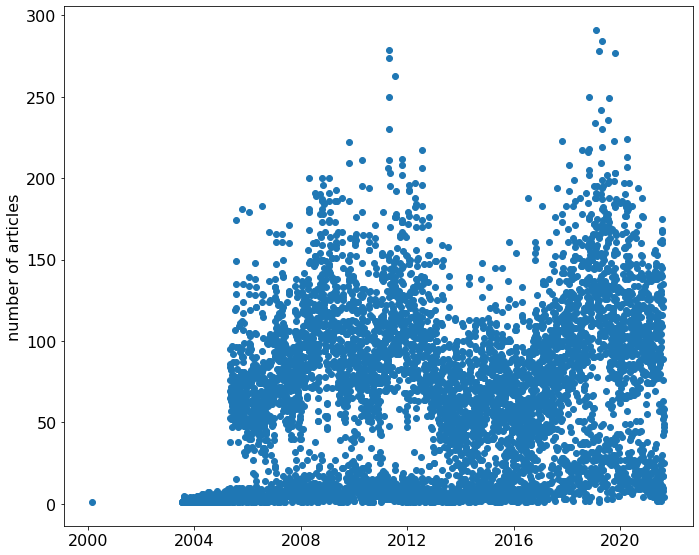

In [14]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10, 8))
data = articles.groupby('date').size();#.plot(ax=ax);
ax.scatter(data.index, data.values);
ax.set_ylabel('number of articles');
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('articles_plot.jpg', dpi=300)
plt.show()

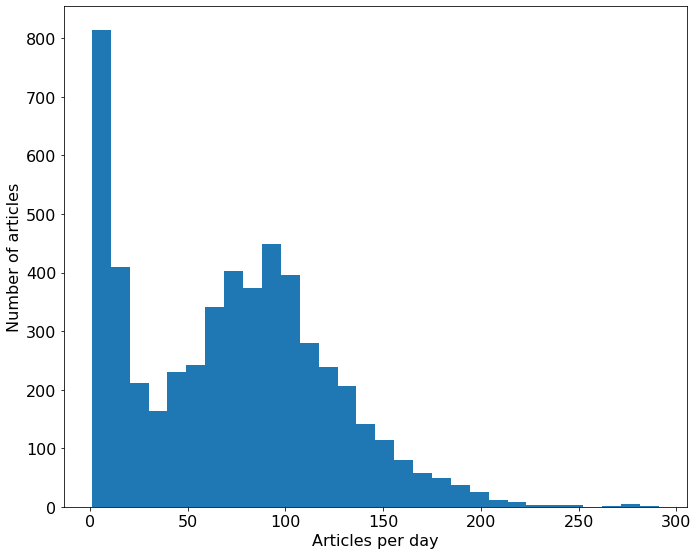

In [30]:
#articles[articles['date'] >= '2007-01-01'].groupby('date').size().hist(bins=30)
# Increase font size for labels and tick marks
plt.rcParams.update({'font.size': 16})

# Your data and plotting code
data = articles[articles['date'] >= '2007-01-01'].groupby('date').size()

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size if needed
data.hist(ax=ax, bins=30)

ax.grid(False)
# Adding x-axis and y-axis labels
ax.set_xlabel('Articles per day')
ax.set_ylabel('Number of articles')

# Save the histogram plot as an image
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('articles_day_histogram.jpg', dpi=300)  # Save as PNG image with high resolution
plt.show()


### The first bin appears to be days with less than 11 articles, which seem to be quite many
### That said, there are weekends and we can throw them out, then we only get 53 "slow" days
### We possibly can throw out holidays, but it doesn't matter all that much

In [18]:
(articles[articles['date'] >= '2007-01-01'].groupby('date').size() < 11).sum()

814

In [19]:
(articles[(articles['date'] >= '2007-01-01') & (articles['date'].dt.weekday < 5)].groupby('date').size() < 11).sum()

53

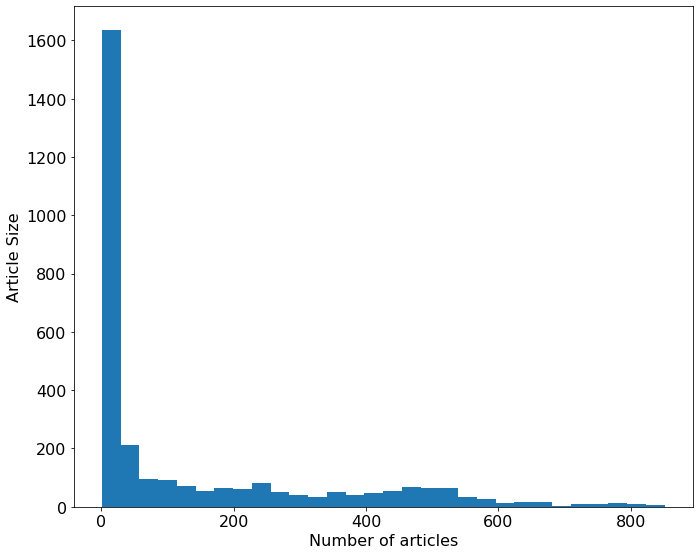

In [36]:
data = articles.groupby('text_size').size()

fig, ax = plt.subplots(figsize=(10, 8))  # Adjust figure size if needed
data.hist(ax=ax, bins=30)

# Remove gridlines
ax.grid(False)

# Adding x-axis and y-axis labels
ax.set_xlabel('Number of articles')
ax.set_ylabel('Article Size')

# Save the histogram plot as an image
plt.tight_layout()  # Adjust layout for better spacing
plt.savefig('articles_size_histogram.jpg', dpi=300)

### Next are some other summary measures per company, such as the earliest and latest article, the number of articles, and the smallest and largest article

In [20]:
summary = articles.groupby('company').agg(
    first = pd.NamedAgg(column='date', aggfunc='min'),
    last = pd.NamedAgg(column='date', aggfunc='max'),
    count = pd.NamedAgg(column='title', aggfunc='count'),
    min_size = pd.NamedAgg(column='text_size', aggfunc='min'),
    max_size = pd.NamedAgg(column='text_size', aggfunc='max')
)

summary.head()

,first,last,count,min_size,max_size
company,,,,,
3M,2005-02-16,2021-08-02,1364,51,15960
A. O. Smith,2005-06-24,2021-07-23,82,76,11527
ADM,2005-05-18,2021-07-27,552,54,12192
AES Corp,2005-05-05,2021-07-29,243,54,6945
APA Corporation,2004-04-16,2021-07-29,646,52,20098


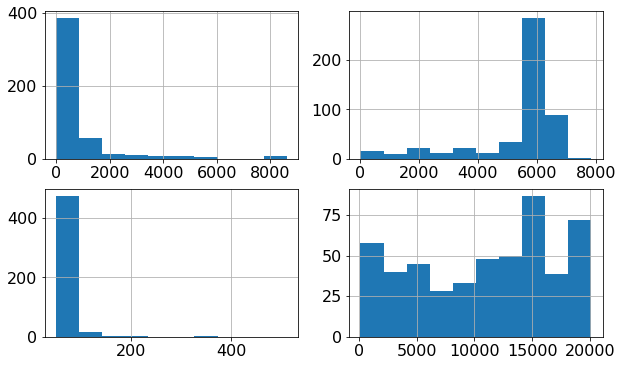

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10,6))
summary['count'].hist(ax=axs[0,0])
(summary['last'] - summary['first']).sort_values().dt.days.hist(ax=axs[0,1])
summary['min_size'].hist(ax=axs[1, 0])
summary['max_size'].hist(ax=axs[1, 1]);

### Let's take a closer look at the articles for 1 company, do some QA
For ADM, most articles are smaller than 2000 words. There are some extreme outliers, which might possibly be mega-articles that mention the entire S&P index.

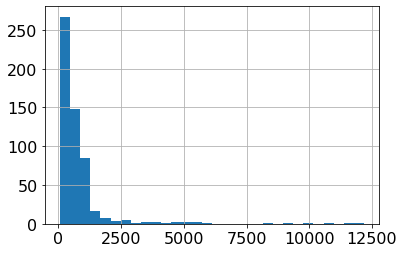

In [22]:
articles[(articles['company']=='ADM')]['text_size'].hist(bins=30);

<AxesSubplot:>

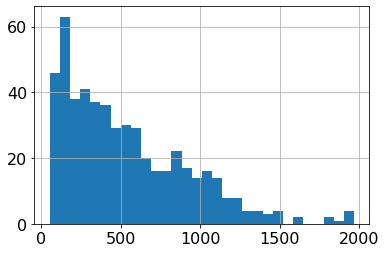

In [23]:
articles[(articles['company']=='ADM') & (articles['text_size'] < 2000)]['text_size'].hist(bins=30)

In [24]:
articles[articles['company'] == 'ADM'].sample(5)

,title,text,href,date,company_idx,company,ticker,text_size
idx,,,,,,,,
29588,"Google, Altria, Merck, Kraft Foods",SAN FRANCISCO (Marketwatch) -- Among the compa...,https://www.marketwatch.com/story/google-altri...,2006-01-30,48,ADM,ADM,985
29245,What to buy as the market tops,You don’t necessarily have to sell all your st...,https://www.marketwatch.com/story/what-to-buy-...,2013-11-08,48,ADM,ADM,1007
29566,"Merck, Rackable, Kodak",SAN FRANCISCO (MarketWatch) -- Among the compa...,https://www.marketwatch.com/story/stocks-expec...,2006-10-30,48,ADM,ADM,1065
29195,Obama’s Pacific trade deal will help these sec...,President Barack Obama suffered a blow to his ...,https://www.marketwatch.com/story/obamas-pacif...,2015-06-12,48,ADM,ADM,493
29562,"Scottish Power, Greenfield Online, Bitstream, ...",Aptimus shares climbed 6.5% Wednesday after th...,https://www.marketwatch.com/story/wednesdays-b...,2006-11-08,48,ADM,ADM,2506


### Here is an example of an article that mentions 4 companies

In [25]:
articles.loc[29476]

,title,text,href,date,company_idx,company,ticker,text_size
idx,,,,,,,,
29476,"Damaging Midwest storms to subside, NWS says",SAN FRANCISCO (MarketWatch) -- Storms that hav...,https://www.marketwatch.com/story/damaging-mid...,2008-06-12,48,ADM,ADM,590
29476,"Damaging Midwest storms to subside, NWS says",SAN FRANCISCO (MarketWatch) -- Storms that hav...,https://www.marketwatch.com/story/damaging-mid...,2008-06-12,156,Duke Energy,DUK,590
29476,"Damaging Midwest storms to subside, NWS says",SAN FRANCISCO (MarketWatch) -- Storms that hav...,https://www.marketwatch.com/story/damaging-mid...,2008-06-12,326,The Mosaic Company,MOS,590
29476,"Damaging Midwest storms to subside, NWS says",SAN FRANCISCO (MarketWatch) -- Storms that hav...,https://www.marketwatch.com/story/damaging-mid...,2008-06-12,454,Tyson Foods,TSN,590


### The problem here is 2-fold. 
First, if many companies are mentioned in an article maybe the sentiment is entity-specific and not the same for all.

Second, how do we extract sentiment from articles larger than ~ 500 tokens, which is the input size of BeRT?

In the following article, every company is mentioned in mostly negative sentiment for the impact of the rain. However, in others this is not the case.

In [26]:
print(articles.loc[29476, 'text'].iloc[0])

SAN FRANCISCO (MarketWatch) -- Storms that have drenched and flooded the Midwest are winding down and expected to ease for a while, allowing the waterlogged heart of the nation to begin recovery, said the National Weather Service Thursday.
After rocking parts of Iowa and other Midwestern states for about a week, the affected area should get a breather for five to six days, said Dan Luna, a Minnesota-based lead hydrologist for the National Weather Service. He sees rains then returning to their normal seasonal levels.
AccuWeather.com, which had forecast a new round of Midwestern storms on Thursday, said it also anticipates heavy rainfall in the region will let up over the next few days.
Damage to roads, bridges, homes and crops appears likely to reach hundreds of millions of dollars because of record flooding in Iowa and major flooding across parts of Minnesota, Wisconsin, Illinois and Indiana, the NWS says. Flood damage calculations can't be complete until waters go down and cleanup beg

### Here we can see that we have roughly 200K articles
### We also see that only 120K of those mention solely 1 company

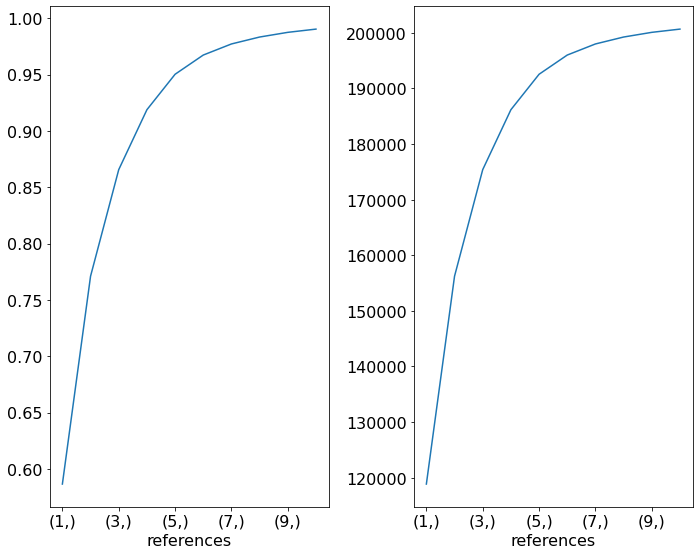

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10,8))
articles.groupby('href').agg(
    references = pd.NamedAgg(column='ticker', aggfunc='count')
).value_counts(normalize=True).cumsum()[:10].plot(ax=axs[0]);
articles.groupby('href').agg(
    references = pd.NamedAgg(column='ticker', aggfunc='count')
).value_counts().cumsum()[:10].plot(ax=axs[1]);
plt.tight_layout();
plt.savefig('article_.jpg', dpi=300)  # Save as PNG image with high resolution

### TODO: Find out how to handle weekend articles and stock price interplay
### TODO1: Run naive sentiment and use the same value for all companies mentioned
### TODO2: Limit list to articles mentioning only 1 company and use that
### TODO3: Limit list to articles mentioning 2, 3, 4, ..., companies and try to single them out in the text, calculating a different sentiment for each one

## First thing, get articles that only mention 1 company and extract their sentiment, then save that in SQL

In [31]:
articles.groupby('idx').size() == 1

idx
8         False
9         False
14         True
15         True
27         True
          ...  
300754     True
300755     True
300757     True
300758     True
300759     True
Length: 202616, dtype: bool